In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
x_train = mnist.train.images
y_train = mnist.train.labels
x_test = mnist.test.images
y_test = mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')
    
def deconv2d(x, W, output_shape):
    return tf.nn.conv2d_transpose(x, W, output_shape, strides=[1,1,1,1], padding='SAME')

def weight_variable(shape):
    initial = tf.random_normal(shape, mean=0.0, stddev=0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.random_normal(shape, mean=0.0, stddev=0.01)
    return tf.Variable(initial)

def max_unpool_2x2(x, output_shape):
    out = tf.concat([x, tf.zeros_like(x)], 3)
    out = tf.concat([out, tf.zeros_like(out)], 2)
    out_size = output_shape
    return tf.reshape(out, out_size)

def max_pool_2x2(x):
    _, argmax = tf.nn.max_pool_with_argmax(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    pool = tf.nn.max_pool(x, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    return pool, argmax

In [24]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape = [None, 784])
x_origin = tf.reshape(x, [-1,28,28,1])


W_e_conv1 = weight_variable([5,5,1,16])
b_e_conv1 = bias_variable([16])
h_e_conv1 = tf.nn.relu(tf.add(conv2d(x_origin, W_e_conv1), b_e_conv1))
h_e_pool1, argmax_e_pool1 = max_pool_2x2(h_e_conv1)

# print max_pool_2x2(h_e_conv1)

W_e_conv2 = weight_variable([5,5,16,32])
b_e_conv2 = bias_variable([32])
h_e_conv2 = tf.nn.relu(tf.add(conv2d(h_e_pool1, W_e_conv2), b_e_conv2))
h_e_pool2, argmax_e_pool2 = max_pool_2x2(h_e_conv2)


# code_layer = argmax_e_pool2
# print("code layer shape : %s" % h_e_pool2.get_shape())

W_d_conv1 = weight_variable([5,5,16,32])
b_d_conv1 = bias_variable([16])
output_shape_d_pool1 = tf.stack([tf.shape(x)[0], 14, 14, 32])
h_d_pool1 = max_unpool_2x2(h_e_pool2, output_shape_d_pool1)
output_shape_d_conv1 = tf.stack([tf.shape(x)[0], 14, 14, 16])
h_d_conv1 = tf.nn.relu(deconv2d(h_d_pool1, W_d_conv1, output_shape_d_conv1)+b_d_conv1)


# print max_unpool_2x2(h_d_conv1, output_shape_d_pool1)

W_d_conv2 = weight_variable([5, 5, 1, 16])
b_d_conv2 = bias_variable([1])
output_shape_d_pool2 = tf.stack([tf.shape(x)[0], 28, 28, 16])
h_d_pool2 = max_unpool_2x2(h_d_conv1, output_shape_d_pool2)
output_shape_d_conv2 = tf.stack([tf.shape(x)[0], 28, 28, 1])
h_d_conv2 = tf.nn.relu(deconv2d(h_d_pool2, W_d_conv2, output_shape_d_conv2)+b_d_conv2)


# print max_unpool_2x2(h_d_conv2, output_shape_d_pool2)

x_reconstruct = h_d_conv2
print("reconstruct layer shape : %s" % x_reconstruct.get_shape())

reconstruct layer shape : (?, 28, 28, 1)


In [31]:
loss = tf.reduce_mean(tf.pow(x_reconstruct - x_origin, 2))
train_step = tf.train.AdamOptimizer(0.000001).minimize(loss)

In [32]:
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

batch_size = 100
batches = x_train.shape[0]//batch_size
index = np.arange(x_train.shape[0])



epoch:  0  , loss:  0.111946
epoch:  10  , loss:  0.0862802
epoch:  20  , loss:  0.0748551
epoch:  30  , loss:  0.0676719
epoch:  40  , loss:  0.0608278
epoch:  50  , loss:  0.0545879
epoch:  60  , loss:  0.0500858
epoch:  70  , loss:  0.0472011
epoch:  80  , loss:  0.045011
epoch:  90  , loss:  0.0431164
epoch:  100  , loss:  0.0414787


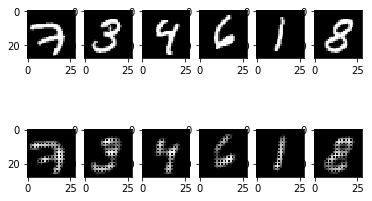

In [33]:
#Autoencoder
for epoch in range(101):    
#     np.random.shuffle(index)
    for batch in range(batches):
        sess.run(train_step, feed_dict={x: x_train[[index[batch_size*batch:batch_size*(batch+1)]]]})
#     sess.run(train_step, feed_dict={xs: x_train[0:100], ys: y_train[0:100]})
    
    if epoch%10==0:
        print "epoch: ",epoch," , loss: ",sess.run(loss, feed_dict={x: x_train})
#         print sess.run(tf.argmax(sess.run(layer1, feed_dict={xs: x_train})[0:50],1))
#         print sess.run(tf.argmax(sess.run(prediction, feed_dict={xs: x_train})[0:50],1))
#         print sess.run(tf.argmax(sess.run(output2, feed_dict={xs: x_train})[0:50],1))
    


x_ae = np.array([np.reshape(m,(28,28)) for m in sess.run(x_reconstruct, feed_dict={x:x_train})])
x_train2 = np.array([np.reshape(m,(28,28)) for m in x_train])

fig, ax = plt.subplots(nrows=2, ncols=6)

for i0 in range(len(ax[0])):
    ax[0][i0].imshow(x_train2[i0], cmap='gray')
for i1 in range(len(ax[1])):
    ax[1][i1].imshow(x_ae[i1], cmap='gray')

epoch:  0  , loss:  0.0413301
epoch:  10  , loss:  0.0400034
epoch:  20  , loss:  0.0389291
epoch:  30  , loss:  0.038055
epoch:  40  , loss:  0.0373354
epoch:  50  , loss:  0.0367285
epoch:  60  , loss:  0.0362141
epoch:  70  , loss:  0.0357695
epoch:  80  , loss:  0.0353831
epoch:  90  , loss:  0.0350456
epoch:  100  , loss:  0.034749
epoch:  110  , loss:  0.0344857
epoch:  120  , loss:  0.0342497
epoch:  130  , loss:  0.0340358
epoch:  140  , loss:  0.0338403
epoch:  150  , loss:  0.0336606
epoch:  160  , loss:  0.0334949
epoch:  170  , loss:  0.0333416
epoch:  180  , loss:  0.0331997
epoch:  190  , loss:  0.033068
epoch:  200  , loss:  0.0329459


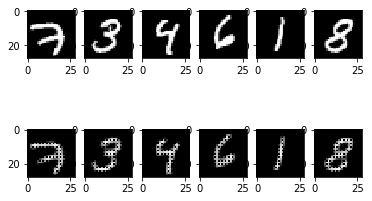

In [34]:
#Autoencoder
for epoch in range(201):    
#     np.random.shuffle(index)
    for batch in range(batches):
        sess.run(train_step, feed_dict={x: x_train[[index[batch_size*batch:batch_size*(batch+1)]]]})
#     sess.run(train_step, feed_dict={xs: x_train[0:100], ys: y_train[0:100]})
    
    if epoch%10==0:
        print "epoch: ",epoch," , loss: ",sess.run(loss, feed_dict={x: x_train})
#         print sess.run(tf.argmax(sess.run(layer1, feed_dict={xs: x_train})[0:50],1))
#         print sess.run(tf.argmax(sess.run(prediction, feed_dict={xs: x_train})[0:50],1))
#         print sess.run(tf.argmax(sess.run(output2, feed_dict={xs: x_train})[0:50],1))
    


x_ae = np.array([np.reshape(m,(28,28)) for m in sess.run(x_reconstruct, feed_dict={x:x_train})])
x_train2 = np.array([np.reshape(m,(28,28)) for m in x_train])

fig, ax = plt.subplots(nrows=2, ncols=6)

for i0 in range(len(ax[0])):
    ax[0][i0].imshow(x_train2[i0], cmap='gray')
for i1 in range(len(ax[1])):
    ax[1][i1].imshow(x_ae[i1], cmap='gray')

epoch:  0  , loss:  0.0329342
epoch:  10  , loss:  0.0328214
epoch:  20  , loss:  0.0327161
epoch:  30  , loss:  0.0326176
epoch:  40  , loss:  0.0325254
epoch:  50  , loss:  0.0324387
epoch:  60  , loss:  0.0323557
epoch:  70  , loss:  0.0322781
epoch:  80  , loss:  0.032205
epoch:  90  , loss:  0.0321357
epoch:  100  , loss:  0.03207
epoch:  110  , loss:  0.032006
epoch:  120  , loss:  0.031945
epoch:  130  , loss:  0.031887
epoch:  140  , loss:  0.0318314
epoch:  150  , loss:  0.0317782
epoch:  160  , loss:  0.031727
epoch:  170  , loss:  0.0316779
epoch:  180  , loss:  0.0316307
epoch:  190  , loss:  0.0315852
epoch:  200  , loss:  0.0315415
epoch:  210  , loss:  0.0314993
epoch:  220  , loss:  0.0314587
epoch:  230  , loss:  0.0314195
epoch:  240  , loss:  0.0313818
epoch:  250  , loss:  0.0313454
epoch:  260  , loss:  0.0313103
epoch:  270  , loss:  0.0312764
epoch:  280  , loss:  0.0312437
epoch:  290  , loss:  0.031212
epoch:  300  , loss:  0.0311813


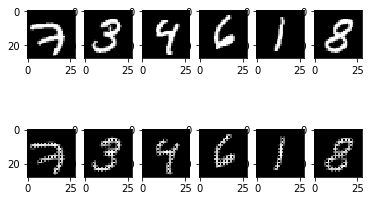

In [35]:
#Autoencoder
for epoch in range(301):    
#     np.random.shuffle(index)
    for batch in range(batches):
        sess.run(train_step, feed_dict={x: x_train[[index[batch_size*batch:batch_size*(batch+1)]]]})
#     sess.run(train_step, feed_dict={xs: x_train[0:100], ys: y_train[0:100]})
    
    if epoch%10==0:
        print "epoch: ",epoch," , loss: ",sess.run(loss, feed_dict={x: x_train})
#         print sess.run(tf.argmax(sess.run(layer1, feed_dict={xs: x_train})[0:50],1))
#         print sess.run(tf.argmax(sess.run(prediction, feed_dict={xs: x_train})[0:50],1))
#         print sess.run(tf.argmax(sess.run(output2, feed_dict={xs: x_train})[0:50],1))
    


x_ae = np.array([np.reshape(m,(28,28)) for m in sess.run(x_reconstruct, feed_dict={x:x_train})])
x_train2 = np.array([np.reshape(m,(28,28)) for m in x_train])

fig, ax = plt.subplots(nrows=2, ncols=6)

for i0 in range(len(ax[0])):
    ax[0][i0].imshow(x_train2[i0], cmap='gray')
for i1 in range(len(ax[1])):
    ax[1][i1].imshow(x_ae[i1], cmap='gray')

epoch:  0  , loss:  0.0311782
epoch:  10  , loss:  0.0311486
epoch:  20  , loss:  0.0311199
epoch:  30  , loss:  0.0310922
epoch:  40  , loss:  0.0310654
epoch:  50  , loss:  0.0310393
epoch:  60  , loss:  0.0310141
epoch:  70  , loss:  0.0309895
epoch:  80  , loss:  0.0309657
epoch:  90  , loss:  0.0309425
epoch:  100  , loss:  0.03092
epoch:  110  , loss:  0.0308981
epoch:  120  , loss:  0.0308768
epoch:  130  , loss:  0.030856
epoch:  140  , loss:  0.0308358
epoch:  150  , loss:  0.0308161
epoch:  160  , loss:  0.0307969
epoch:  170  , loss:  0.0307782
epoch:  180  , loss:  0.0307599
epoch:  190  , loss:  0.030742
epoch:  200  , loss:  0.0307246


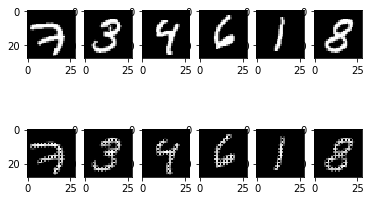

In [36]:
#Autoencoder
for epoch in range(201):    
#     np.random.shuffle(index)
    for batch in range(batches):
        sess.run(train_step, feed_dict={x: x_train[[index[batch_size*batch:batch_size*(batch+1)]]]})
#     sess.run(train_step, feed_dict={xs: x_train[0:100], ys: y_train[0:100]})
    
    if epoch%10==0:
        print "epoch: ",epoch," , loss: ",sess.run(loss, feed_dict={x: x_train})
#         print sess.run(tf.argmax(sess.run(layer1, feed_dict={xs: x_train})[0:50],1))
#         print sess.run(tf.argmax(sess.run(prediction, feed_dict={xs: x_train})[0:50],1))
#         print sess.run(tf.argmax(sess.run(output2, feed_dict={xs: x_train})[0:50],1))
    


x_ae = np.array([np.reshape(m,(28,28)) for m in sess.run(x_reconstruct, feed_dict={x:x_train})])
x_train2 = np.array([np.reshape(m,(28,28)) for m in x_train])

fig, ax = plt.subplots(nrows=2, ncols=6)

for i0 in range(len(ax[0])):
    ax[0][i0].imshow(x_train2[i0], cmap='gray')
for i1 in range(len(ax[1])):
    ax[1][i1].imshow(x_ae[i1], cmap='gray')

epoch:  0  , loss:  0.0307229
epoch:  10  , loss:  0.0307059
epoch:  20  , loss:  0.0306892
epoch:  30  , loss:  0.030673
epoch:  40  , loss:  0.0306571
epoch:  50  , loss:  0.0306415
epoch:  60  , loss:  0.0306262
epoch:  70  , loss:  0.0306113
epoch:  80  , loss:  0.0305966
epoch:  90  , loss:  0.0305822
epoch:  100  , loss:  0.0305681
epoch:  110  , loss:  0.0305543
epoch:  120  , loss:  0.0305407
epoch:  130  , loss:  0.0305274
epoch:  140  , loss:  0.0305142
epoch:  150  , loss:  0.0305014
epoch:  160  , loss:  0.0304887
epoch:  170  , loss:  0.0304762
epoch:  180  , loss:  0.0304639
epoch:  190  , loss:  0.0304519
epoch:  200  , loss:  0.03044
epoch:  210  , loss:  0.0304283
epoch:  220  , loss:  0.0304168
epoch:  230  , loss:  0.0304054
epoch:  240  , loss:  0.0303942
epoch:  250  , loss:  0.0303832
epoch:  260  , loss:  0.0303724
epoch:  270  , loss:  0.0303617
epoch:  280  , loss:  0.0303512
epoch:  290  , loss:  0.0303408
epoch:  300  , loss:  0.0303306
epoch:  310  , loss:  

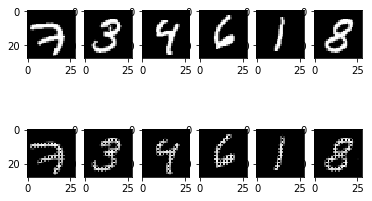

In [37]:
#Autoencoder
for epoch in range(501):    
#     np.random.shuffle(index)
    for batch in range(batches):
        sess.run(train_step, feed_dict={x: x_train[[index[batch_size*batch:batch_size*(batch+1)]]]})
#     sess.run(train_step, feed_dict={xs: x_train[0:100], ys: y_train[0:100]})
    
    if epoch%10==0:
        print "epoch: ",epoch," , loss: ",sess.run(loss, feed_dict={x: x_train})
#         print sess.run(tf.argmax(sess.run(layer1, feed_dict={xs: x_train})[0:50],1))
#         print sess.run(tf.argmax(sess.run(prediction, feed_dict={xs: x_train})[0:50],1))
#         print sess.run(tf.argmax(sess.run(output2, feed_dict={xs: x_train})[0:50],1))
    


x_ae = np.array([np.reshape(m,(28,28)) for m in sess.run(x_reconstruct, feed_dict={x:x_train})])
x_train2 = np.array([np.reshape(m,(28,28)) for m in x_train])

fig, ax = plt.subplots(nrows=2, ncols=6)

for i0 in range(len(ax[0])):
    ax[0][i0].imshow(x_train2[i0], cmap='gray')
for i1 in range(len(ax[1])):
    ax[1][i1].imshow(x_ae[i1], cmap='gray')

epoch:  0  , loss:  0.0301501
epoch:  10  , loss:  0.0301422
epoch:  20  , loss:  0.0301343
epoch:  30  , loss:  0.0301266
epoch:  40  , loss:  0.0301189
epoch:  50  , loss:  0.0301113
epoch:  60  , loss:  0.0301037
epoch:  70  , loss:  0.0300963
epoch:  80  , loss:  0.0300889
epoch:  90  , loss:  0.0300816
epoch:  100  , loss:  0.0300744
epoch:  110  , loss:  0.0300672
epoch:  120  , loss:  0.0300602
epoch:  130  , loss:  0.0300532
epoch:  140  , loss:  0.0300462
epoch:  150  , loss:  0.0300393
epoch:  160  , loss:  0.0300325
epoch:  170  , loss:  0.0300258
epoch:  180  , loss:  0.0300191
epoch:  190  , loss:  0.0300125
epoch:  200  , loss:  0.030006
epoch:  210  , loss:  0.0299995
epoch:  220  , loss:  0.0299931
epoch:  230  , loss:  0.0299867
epoch:  240  , loss:  0.0299804
epoch:  250  , loss:  0.0299741
epoch:  260  , loss:  0.029968
epoch:  270  , loss:  0.0299618
epoch:  280  , loss:  0.0299557
epoch:  290  , loss:  0.0299497
epoch:  300  , loss:  0.0299437
epoch:  310  , loss: 

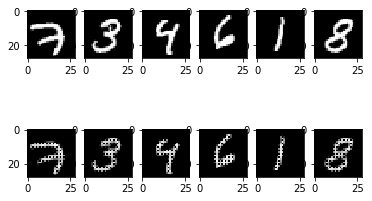

In [38]:
#Autoencoder
for epoch in range(1001):    
#     np.random.shuffle(index)
    for batch in range(batches):
        sess.run(train_step, feed_dict={x: x_train[[index[batch_size*batch:batch_size*(batch+1)]]]})
#     sess.run(train_step, feed_dict={xs: x_train[0:100], ys: y_train[0:100]})
    
    if epoch%10==0:
        print "epoch: ",epoch," , loss: ",sess.run(loss, feed_dict={x: x_train})
#         print sess.run(tf.argmax(sess.run(layer1, feed_dict={xs: x_train})[0:50],1))
#         print sess.run(tf.argmax(sess.run(prediction, feed_dict={xs: x_train})[0:50],1))
#         print sess.run(tf.argmax(sess.run(output2, feed_dict={xs: x_train})[0:50],1))
    


x_ae = np.array([np.reshape(m,(28,28)) for m in sess.run(x_reconstruct, feed_dict={x:x_train})])
x_train2 = np.array([np.reshape(m,(28,28)) for m in x_train])

fig, ax = plt.subplots(nrows=2, ncols=6)

for i0 in range(len(ax[0])):
    ax[0][i0].imshow(x_train2[i0], cmap='gray')
for i1 in range(len(ax[1])):
    ax[1][i1].imshow(x_ae[i1], cmap='gray')

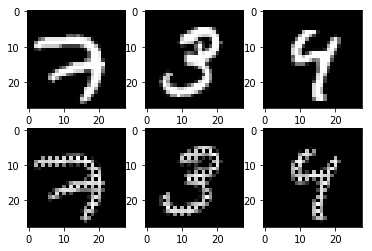

In [39]:
fig, ax = plt.subplots(nrows=2, ncols=3)

for i0 in range(len(ax[0])):
    ax[0][i0].imshow(x_train2[i0], cmap='gray')
for i1 in range(len(ax[1])):
    ax[1][i1].imshow(x_ae[i1], cmap='gray')